## Autoencoders
### Deteccion de anomalias usando autoencoders

Anomaly Detection using AutoEncoders

AutoEncoders are widely used in anomaly detection. _The reconstruction errors are used as the anomaly scores_. Let us look at how we can use AutoEncoder for anomaly detection using TensorFlow.

Import the required libraries and load the data. Here we are using the ECG data which consists of labels 0 and 1. Label 0 denotes the observation as an anomaly and label 1 denotes the observation as normal.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

# data shape
# (4998, 141)

2022-11-26 10:47:19.418472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 10:47:19.799615: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-26 10:47:20.536410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-26 10:47:20.536469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
data.shape

(4998, 141)

In [3]:
data.loc[:,140].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [4]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)


Como lo que nos interesa es detectar cuales son los novedosos, usamos solo los datos normales para entrenar (queremos provocar la diferencia)

In [5]:
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

In [6]:
# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

The last column in the data is the target ( column name is 140). Split the data for training and testing and scale the data using MinMaxScaler.

In [17]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=500,
    batch_size=2000,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/500
2/2 [==============================] - 1s 124ms/step - loss: 0.0121 - mse: 0.0267 - val_loss: 0.0138 - val_mse: 0.0316
Epoch 2/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0119 - mse: 0.0262 - val_loss: 0.0137 - val_mse: 0.0314
Epoch 3/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0117 - mse: 0.0259 - val_loss: 0.0136 - val_mse: 0.0311
Epoch 4/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0114 - mse: 0.0252 - val_loss: 0.0133 - val_mse: 0.0305
Epoch 5/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0109 - mse: 0.0241 - val_loss: 0.0130 - val_mse: 0.0298
Epoch 6/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0102 - mse: 0.0224 - val_loss: 0.0127 - val_mse: 0.0293
Epoch 7/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0093 - mse: 0.0205 - val_loss: 0.0128 - val_mse: 0.0295
Epoch 8/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0086 - mse: 0.0

2/2 [==============================] - 0s 19ms/step - loss: 0.0039 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0214
Epoch 64/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0039 - mse: 0.0087 - val_loss: 0.0093 - val_mse: 0.0215
Epoch 65/500
2/2 [==============================] - 0s 18ms/step - loss: 0.0038 - mse: 0.0086 - val_loss: 0.0092 - val_mse: 0.0213
Epoch 66/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0038 - mse: 0.0086 - val_loss: 0.0093 - val_mse: 0.0215
Epoch 67/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0038 - mse: 0.0085 - val_loss: 0.0092 - val_mse: 0.0213
Epoch 68/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0038 - mse: 0.0084 - val_loss: 0.0092 - val_mse: 0.0213
Epoch 69/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0037 - mse: 0.0084 - val_loss: 0.0093 - val_mse: 0.0214
Epoch 70/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0037 - mse: 0.0083 - 

2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - mse: 0.0065 - val_loss: 0.0088 - val_mse: 0.0202
Epoch 126/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - mse: 0.0065 - val_loss: 0.0087 - val_mse: 0.0200
Epoch 127/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0029 - mse: 0.0065 - val_loss: 0.0088 - val_mse: 0.0203
Epoch 128/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - mse: 0.0065 - val_loss: 0.0089 - val_mse: 0.0204
Epoch 129/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - mse: 0.0064 - val_loss: 0.0090 - val_mse: 0.0206
Epoch 130/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0029 - mse: 0.0064 - val_loss: 0.0088 - val_mse: 0.0202
Epoch 131/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - mse: 0.0064 - val_loss: 0.0088 - val_mse: 0.0202
Epoch 132/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0028 - mse: 0.

2/2 [==============================] - 0s 21ms/step - loss: 0.0026 - mse: 0.0057 - val_loss: 0.0084 - val_mse: 0.0192
Epoch 188/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0026 - mse: 0.0057 - val_loss: 0.0084 - val_mse: 0.0193
Epoch 189/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0025 - mse: 0.0057 - val_loss: 0.0084 - val_mse: 0.0192
Epoch 190/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0026 - mse: 0.0057 - val_loss: 0.0084 - val_mse: 0.0194
Epoch 191/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0026 - mse: 0.0057 - val_loss: 0.0084 - val_mse: 0.0194
Epoch 192/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0026 - mse: 0.0057 - val_loss: 0.0086 - val_mse: 0.0197
Epoch 193/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0025 - mse: 0.0056 - val_loss: 0.0086 - val_mse: 0.0198
Epoch 194/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0025 - mse: 0.

2/2 [==============================] - 0s 23ms/step - loss: 0.0023 - mse: 0.0051 - val_loss: 0.0081 - val_mse: 0.0185
Epoch 250/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0023 - mse: 0.0050 - val_loss: 0.0081 - val_mse: 0.0184
Epoch 251/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0023 - mse: 0.0051 - val_loss: 0.0081 - val_mse: 0.0184
Epoch 252/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0023 - mse: 0.0051 - val_loss: 0.0081 - val_mse: 0.0186
Epoch 253/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0023 - mse: 0.0050 - val_loss: 0.0082 - val_mse: 0.0187
Epoch 254/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0023 - mse: 0.0050 - val_loss: 0.0082 - val_mse: 0.0188
Epoch 255/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0023 - mse: 0.0050 - val_loss: 0.0082 - val_mse: 0.0186
Epoch 256/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0023 - mse: 0.

2/2 [==============================] - 0s 20ms/step - loss: 0.0021 - mse: 0.0047 - val_loss: 0.0080 - val_mse: 0.0182
Epoch 312/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0021 - mse: 0.0047 - val_loss: 0.0079 - val_mse: 0.0181
Epoch 313/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0021 - mse: 0.0047 - val_loss: 0.0078 - val_mse: 0.0177
Epoch 314/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0021 - mse: 0.0047 - val_loss: 0.0078 - val_mse: 0.0178
Epoch 315/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0021 - mse: 0.0047 - val_loss: 0.0078 - val_mse: 0.0177
Epoch 316/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0021 - mse: 0.0047 - val_loss: 0.0077 - val_mse: 0.0176
Epoch 317/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0021 - mse: 0.0047 - val_loss: 0.0078 - val_mse: 0.0178
Epoch 318/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0021 - mse: 0.

2/2 [==============================] - 0s 21ms/step - loss: 0.0020 - mse: 0.0044 - val_loss: 0.0078 - val_mse: 0.0179
Epoch 374/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0020 - mse: 0.0044 - val_loss: 0.0078 - val_mse: 0.0178
Epoch 375/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0020 - mse: 0.0044 - val_loss: 0.0079 - val_mse: 0.0181
Epoch 376/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0020 - mse: 0.0044 - val_loss: 0.0080 - val_mse: 0.0182
Epoch 377/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0020 - mse: 0.0044 - val_loss: 0.0079 - val_mse: 0.0180
Epoch 378/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0020 - mse: 0.0044 - val_loss: 0.0080 - val_mse: 0.0182
Epoch 379/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0043 - val_loss: 0.0081 - val_mse: 0.0185
Epoch 380/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0020 - mse: 0.

2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0041 - val_loss: 0.0077 - val_mse: 0.0175
Epoch 436/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0042 - val_loss: 0.0074 - val_mse: 0.0170
Epoch 437/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0019 - mse: 0.0042 - val_loss: 0.0073 - val_mse: 0.0167
Epoch 438/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0019 - mse: 0.0042 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 439/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0019 - mse: 0.0042 - val_loss: 0.0072 - val_mse: 0.0166
Epoch 440/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0042 - val_loss: 0.0074 - val_mse: 0.0170
Epoch 441/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0042 - val_loss: 0.0075 - val_mse: 0.0171
Epoch 442/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0019 - mse: 0.

2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - mse: 0.0041 - val_loss: 0.0075 - val_mse: 0.0171
Epoch 498/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0018 - mse: 0.0040 - val_loss: 0.0075 - val_mse: 0.0172
Epoch 499/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - mse: 0.0041 - val_loss: 0.0074 - val_mse: 0.0170
Epoch 500/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - mse: 0.0041 - val_loss: 0.0073 - val_mse: 0.0168


In [11]:

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0049 - mse: 0.0108 - val_loss: 0.0101 - val_mse: 0.0233
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 0.0104 - val_loss: 0.0101 - val_mse: 0.0232
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 0.0103 - val_loss: 0.0100 - val_mse: 0.0231
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 0.0102 - val_loss: 0.0100 - val_mse: 0.0232
Epoch 5/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 0.0100 - val_loss: 0.0100 - val_mse: 0.0231
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 0.0099 - val_loss: 0.0100 - val_mse: 0.0230
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 0.0099 - val_loss: 0.0099 - val_mse: 0.0229
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 0.0098 - val_loss: 

The encoder of the model consists of four layers that encode the data into lower dimensions. The decoder of the model consists of four layers that reconstruct the input data.

The model is compiled with Mean Squared Logarithmic loss and Adam optimizer. The model is then trained with 20 epochs with a batch size of 512.

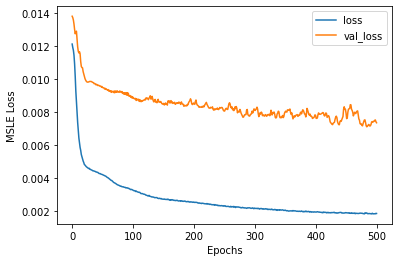

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [19]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) \
    + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

# 0.944

73/73 [==============================] - 0s 870us/step
Threshold: 0.004093334089714702
32/32 [==============================] - 0s 810us/step


0.967

The reconstruction errors are considered to be anomaly scores. The threshold is then calculated by summing the mean and standard deviation of the reconstruction errors. The reconstruction errors above this threshold are considered to be anomalies. We can further fine-tune the model by leveraging Keras-tuner.

 

The autoencoder model does not have to symmetric encoder and decoder but the code size has to be smaller than that of the features in the data

## Dimensionality Reduction using AutoEncoders

In [39]:
import math
import pandas as pd
import tensorflow as tf
#import kerastuner.tuners as kt
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, Conv2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [21]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [24]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [23]:
data = pd.DataFrame(california.data,columns = california.feature_names)
target = pd.DataFrame(california.target,columns = california.target_names)

x_train,x_test, y_train,_y_test = train_test_split(data,target,test_size=0.3,random_state=123)

Scale the dataset using MinMaxScaler.

In [26]:

def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    """
    standard_scaler = MinMaxScaler()
    x_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(x_train),
        columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        standard_scaler.transform(x_test),
        columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled
  
x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

Train the autoencoder with the training data.

In [43]:
class AutoEncoders(Model):
    def __init__(self, output_units):
        super().__init__()
        self.encoder = Sequential(
            [
                Dense(64, activation="relu"),
                Dense(32, activation="relu"),
                Dense(16, activation="relu"),
                Dense(7, activation="relu")
            ]
        )
        
        self.decoder = Sequential(
            [
                Dense(16, activation="relu"),
                Dense(32, activation="relu"),
                Dense(output_units, activation="sigmoid")
            ]
        )
        ## AQUI HABIA UN ERROR EN EL PROGRAMA!!
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
    
auto_encoder = AutoEncoders(len(x_train_scaled.columns))

auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)

history = auto_encoder.fit(
    x_train_scaled, 
    x_train_scaled, 
    epochs=15, 
    batch_size=32, 
    validation_data=(x_test_scaled, x_test_scaled)
)


Epoch 1/15
452/452 [==============================] - 2s 3ms/step - loss: 0.0871 - mae: 0.0871 - val_loss: 0.0287 - val_mae: 0.0287
Epoch 2/15
452/452 [==============================] - 1s 3ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0261 - val_mae: 0.0261
Epoch 3/15
452/452 [==============================] - 1s 3ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0251 - val_mae: 0.0251
Epoch 4/15
452/452 [==============================] - 1s 2ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0181 - val_mae: 0.0181
Epoch 5/15
452/452 [==============================] - 1s 3ms/step - loss: 0.0163 - mae: 0.0163 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 6/15
452/452 [==============================] - 1s 2ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0144 - val_mae: 0.0144
Epoch 7/15
452/452 [==============================] - 1s 2ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 8/15
452/452 [==============================] - 1s 3ms/step - loss: 0.

Here we have defined the autoencoder model by subclassing the Model class in Tensorflow and we compile the AutoEncoder model with mean absolute error and adam optimization function. We split the data into batches of 32 and we run it for 15 epochs.

Get the encoder layer and use the method predict to reduce dimensions in data. Since we have seven hidden units in the bottleneck the data is reduced to seven features.

In [45]:
encoder_layer = auto_encoder.get_layer('sequential_14')
reduced_df = pd.DataFrame(encoder_layer.predict(x_train_scaled))
reduced_df = reduced_df.add_prefix('feature_')

452/452 [==============================] - 0s 766us/step


In [47]:
reduced_df['feature_6'].value_counts()

0.0    14448
Name: feature_6, dtype: int64

In this way, AutoEncoders can be used to reduce dimensions in data.

`https://towardsdatascience.com/image-colorization-using-convolutional-autoencoders-fdabc1cb1dbe`